In [6]:
!pip install --upgrade pip

  Using cached pip-21.0-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01


In [7]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-ghp9ro2_
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-ghp9ro2_


In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D,Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import InceptionResNetV2,EfficientNetB3,ResNet50,EfficientNetB4
import itertools
import json
from sklearn.model_selection import StratifiedKFold
import collections
import os
import shutil
import random
import glob
import matplotlib
import cv2
import matplotlib.pyplot as plt

In [9]:
train_path = '../input/cassava-leaf-disease-classification/train_images'

In [10]:
# Print num of images
train_num = sum(len(files) for _, _, files in os.walk(train_path))
print(train_num)

21397


In [11]:
# Read CSV file
df_train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv',dtype=str)
df_train.head(5)

image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1
3  1000723321.jpg     1
4  1000812911.jpg     3

In [12]:
#Mapping class lables [0,1,..] to class names
CLASS_INDEX = json.load(open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'))

MAP_CLASS ={int(x):y for x,y in CLASS_INDEX.items()}
MAP_CLASS

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [13]:
# function to visualize class images
def visualize_class(class_name):
    fig = plt.figure(figsize=(10, 10))
    columns = 2
    rows = 1
    imgnames = list(df_train[df_train['label']==class_name].iloc[:2]['image_id'])
    for i in range(len(imgnames)):
        img_name = imgnames[i]
        im = cv2.imread(train_path +'/'+ img_name)
        fig.add_subplot(rows, columns, int(i)+1)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(class_name)

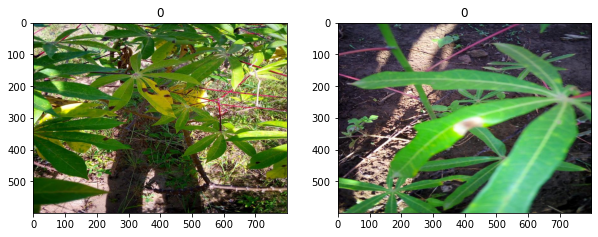

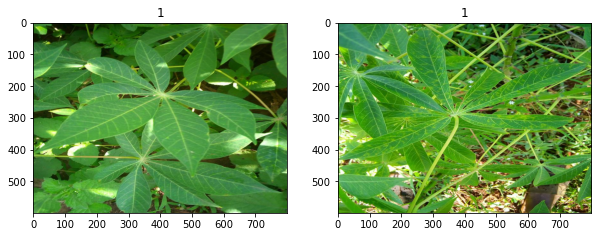

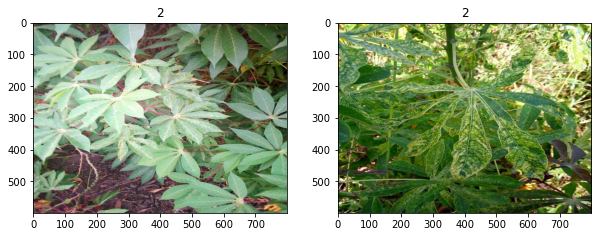

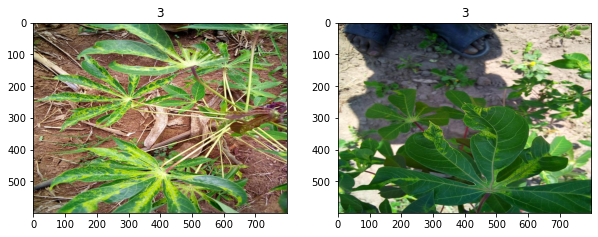

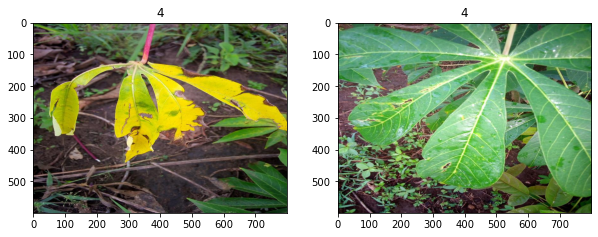

In [14]:
#plot images
visualize_class('0')
visualize_class('1')
visualize_class('2')
visualize_class('3')
visualize_class('4')

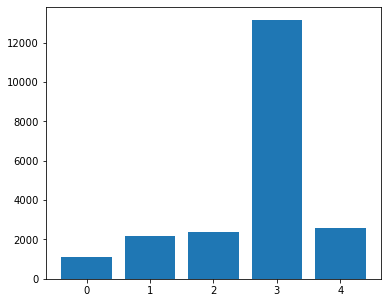

odict_values([1087, 2189, 2386, 13158, 2577])


In [15]:
#Visualize class balance
matplotlib.rcParams['figure.figsize'] = [6, 5]
labels = collections.Counter(np.array(df_train['label']))
labels = collections.OrderedDict(sorted(labels.items()))
plt.bar(list(map(str,labels.keys())), labels.values())
plt.show()
print(labels.values())

In [16]:
# KF cross validation
Y = df_train[['label']]
X = df_train['image_id']   
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) 

In [18]:
#ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

train_aug = albumentations.Compose([
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.Normalize(
               mean=[0.485, 0.456, 0.406], 
               std =[0.229, 0.224, 0.225], 
               max_pixel_value=255.0, 
               p=1.0),albumentations.ToFloat()], p=1.)
  
        
valid_aug = albumentations.Compose([
            albumentations.Normalize(
               mean=[0.485, 0.456, 0.406], 
               std =[0.229, 0.224, 0.225], 
               max_pixel_value=255.0, 
               p=1.0),albumentations.ToFloat()], p=1.)

In [19]:
# ImageDataAugmentor
def data_generator(training_data,validation_data):
    IMG_SHAPE  = 380
    BATCH_SIZE = 32
    
    image_gen_train = ImageDataAugmentor(augment=train_aug,seed=42)
    image_gen_valid = ImageDataAugmentor(augment=valid_aug,seed=42)

    train_data_gen = image_gen_train.flow_from_dataframe(training_data,
                                                    directory=train_path,
                                                    x_col="image_id",
                                                    y_col="label",
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(IMG_SHAPE,IMG_SHAPE))

    valid_data_gen = image_gen_valid.flow_from_dataframe(validation_data,
                                                    directory=train_path,
                                                    x_col="image_id",
                                                    y_col="label",
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode="categorical",
                                                    target_size=(IMG_SHAPE,IMG_SHAPE))

    return train_data_gen, valid_data_gen

In [20]:
# Plot augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [21]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [22]:
def create_new_model():    
    input_t = Input(shape=(380, 380, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor = input_t )
    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')])
    return model  

In [23]:
model = create_new_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 12, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
_________________________________________________________________


1-fold training
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


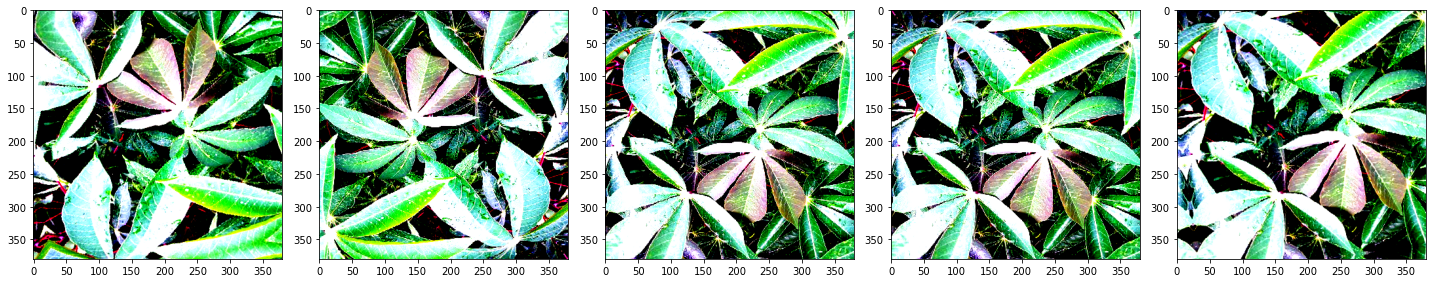

Epoch 1/7
535/535 [==============================] - ETA: 0s - loss: 0.9120 - categorical_accuracy: 0.6631 - AUC: 0.8099
Epoch 00001: val_categorical_accuracy improved from -inf to 0.60444, saving model to ./model_1.h5
535/535 [==============================] - 469s 876ms/step - loss: 0.9120 - categorical_accuracy: 0.6631 - AUC: 0.8099 - val_loss: 1.0635 - val_categorical_accuracy: 0.6044 - val_AUC: 0.7647
Epoch 2/7
535/535 [==============================] - ETA: 0s - loss: 0.5958 - categorical_accuracy: 0.7859 - AUC: 0.9251
Epoch 00002: val_categorical_accuracy improved from 0.60444 to 0.81799, saving model to ./model_1.h5
535/535 [==============================] - 374s 700ms/step - loss: 0.5958 - categorical_accuracy: 0.7859 - AUC: 0.9251 - val_loss: 0.5187 - val_categorical_accuracy: 0.8180 - val_AUC: 0.9447
Epoch 3/7
535/535 [==============================] - ETA: 0s - loss: 0.5027 - categorical_accuracy: 0.8238 - AUC: 0.9447
Epoch 00003: val_categorical_accuracy improved from 0.81

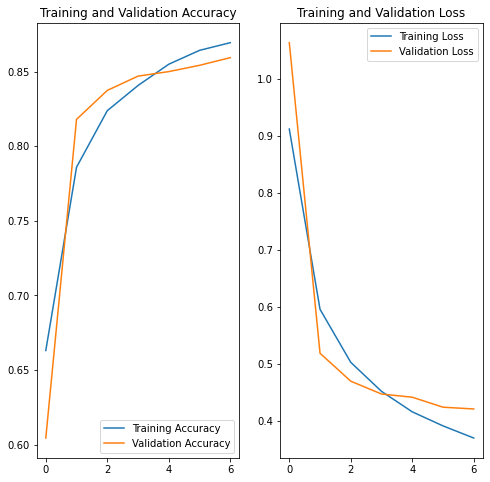

134/134 [==============================] - 61s 454ms/step - loss: 0.4210 - categorical_accuracy: 0.8593 - AUC: 0.9612
2-fold training
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


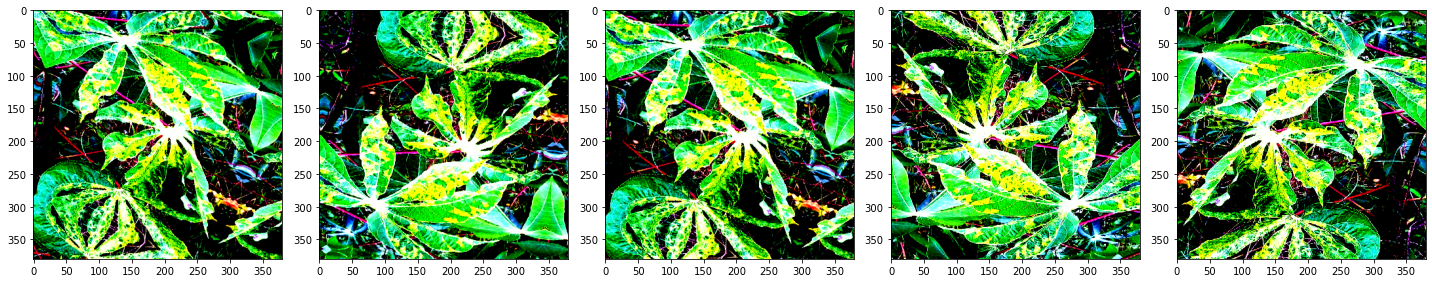

Epoch 1/7
535/535 [==============================] - ETA: 0s - loss: 0.8892 - categorical_accuracy: 0.6739 - AUC: 0.8242
Epoch 00001: val_categorical_accuracy improved from -inf to 0.37079, saving model to ./model_2.h5
535/535 [==============================] - 380s 711ms/step - loss: 0.8892 - categorical_accuracy: 0.6739 - AUC: 0.8242 - val_loss: 1.5490 - val_categorical_accuracy: 0.3708 - val_AUC: 0.7435
Epoch 2/7
535/535 [==============================] - ETA: 0s - loss: 0.6004 - categorical_accuracy: 0.7828 - AUC: 0.9240
Epoch 00002: val_categorical_accuracy improved from 0.37079 to 0.82453, saving model to ./model_2.h5
535/535 [==============================] - 377s 705ms/step - loss: 0.6004 - categorical_accuracy: 0.7828 - AUC: 0.9240 - val_loss: 0.5029 - val_categorical_accuracy: 0.8245 - val_AUC: 0.9451
Epoch 3/7
535/535 [==============================] - ETA: 0s - loss: 0.5039 - categorical_accuracy: 0.8241 - AUC: 0.9451
Epoch 00003: val_categorical_accuracy improved from 0.82

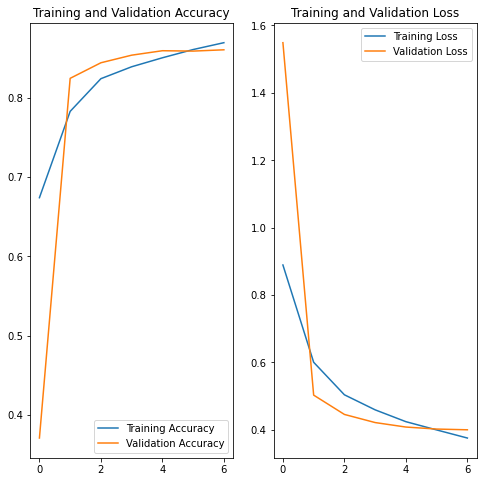

134/134 [==============================] - 64s 474ms/step - loss: 0.4000 - categorical_accuracy: 0.8605 - AUC: 0.9620
3-fold training
Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


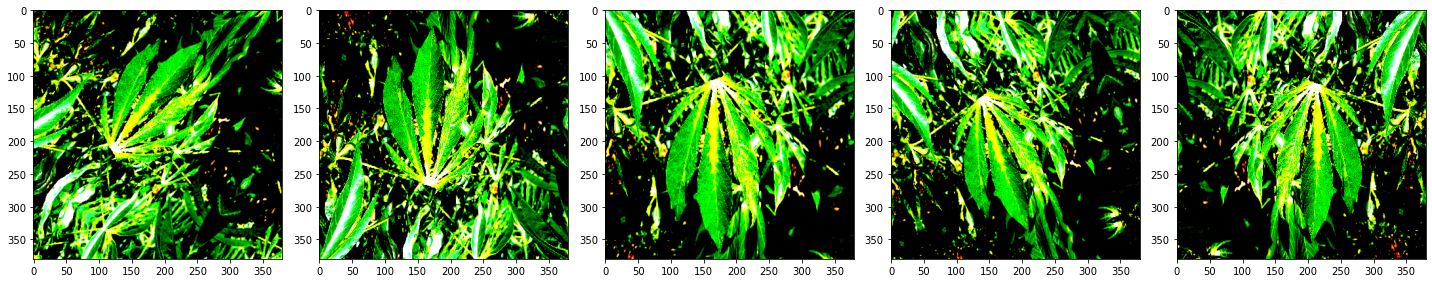

Epoch 1/7
535/535 [==============================] - ETA: 0s - loss: 0.8948 - categorical_accuracy: 0.6689 - AUC: 0.8214
Epoch 00001: val_categorical_accuracy improved from -inf to 0.42416, saving model to ./model_3.h5
535/535 [==============================] - 380s 711ms/step - loss: 0.8948 - categorical_accuracy: 0.6689 - AUC: 0.8214 - val_loss: 1.3277 - val_categorical_accuracy: 0.4242 - val_AUC: 0.7266
Epoch 2/7
535/535 [==============================] - ETA: 0s - loss: 0.5861 - categorical_accuracy: 0.7884 - AUC: 0.9283
Epoch 00002: val_categorical_accuracy improved from 0.42416 to 0.80229, saving model to ./model_3.h5
535/535 [==============================] - 377s 704ms/step - loss: 0.5861 - categorical_accuracy: 0.7884 - AUC: 0.9283 - val_loss: 0.5397 - val_categorical_accuracy: 0.8023 - val_AUC: 0.9369
Epoch 3/7
535/535 [==============================] - ETA: 0s - loss: 0.4988 - categorical_accuracy: 0.8216 - AUC: 0.9466
Epoch 00003: val_categorical_accuracy improved from 0.80

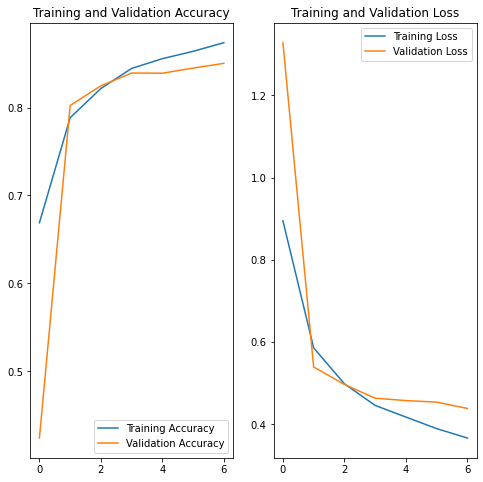

134/134 [==============================] - 62s 462ms/step - loss: 0.4390 - categorical_accuracy: 0.8502 - AUC: 0.9553
4-fold training
Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


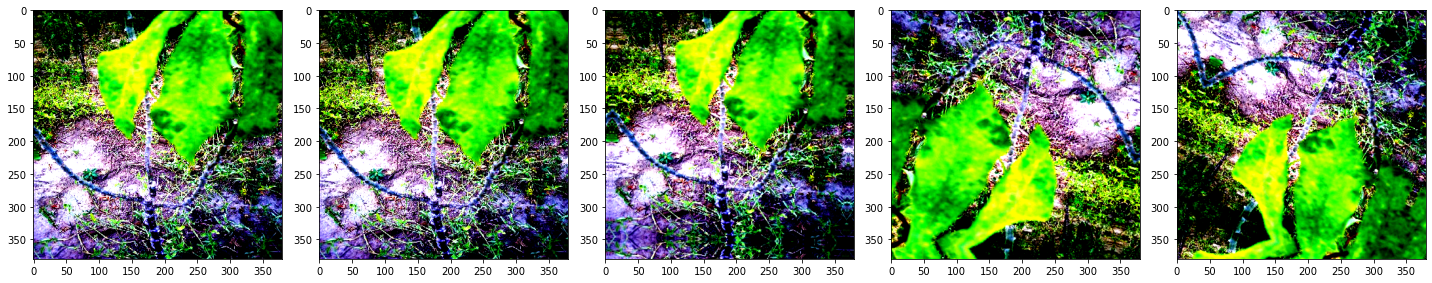

Epoch 1/7
535/535 [==============================] - ETA: 0s - loss: 0.9095 - categorical_accuracy: 0.6609 - AUC: 0.8134
Epoch 00001: val_categorical_accuracy improved from -inf to 0.44590, saving model to ./model_4.h5
535/535 [==============================] - 380s 710ms/step - loss: 0.9095 - categorical_accuracy: 0.6609 - AUC: 0.8134 - val_loss: 1.3402 - val_categorical_accuracy: 0.4459 - val_AUC: 0.7497
Epoch 2/7
535/535 [==============================] - ETA: 0s - loss: 0.5916 - categorical_accuracy: 0.7900 - AUC: 0.9271
Epoch 00002: val_categorical_accuracy improved from 0.44590 to 0.79715, saving model to ./model_4.h5
535/535 [==============================] - 377s 705ms/step - loss: 0.5916 - categorical_accuracy: 0.7900 - AUC: 0.9271 - val_loss: 0.5515 - val_categorical_accuracy: 0.7971 - val_AUC: 0.9335
Epoch 3/7
535/535 [==============================] - ETA: 0s - loss: 0.4946 - categorical_accuracy: 0.8268 - AUC: 0.9472
Epoch 00003: val_categorical_accuracy improved from 0.79

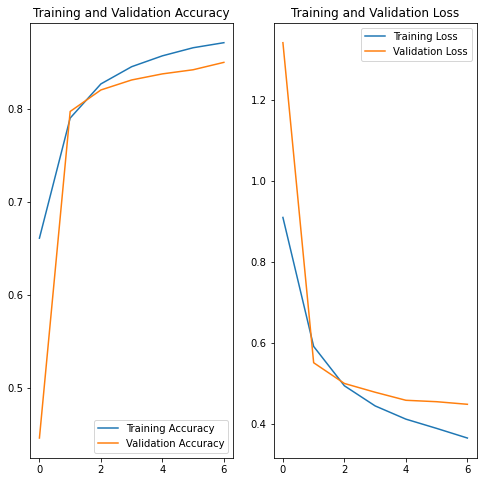

134/134 [==============================] - 61s 456ms/step - loss: 0.4491 - categorical_accuracy: 0.8500 - AUC: 0.9528
5-fold training
Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


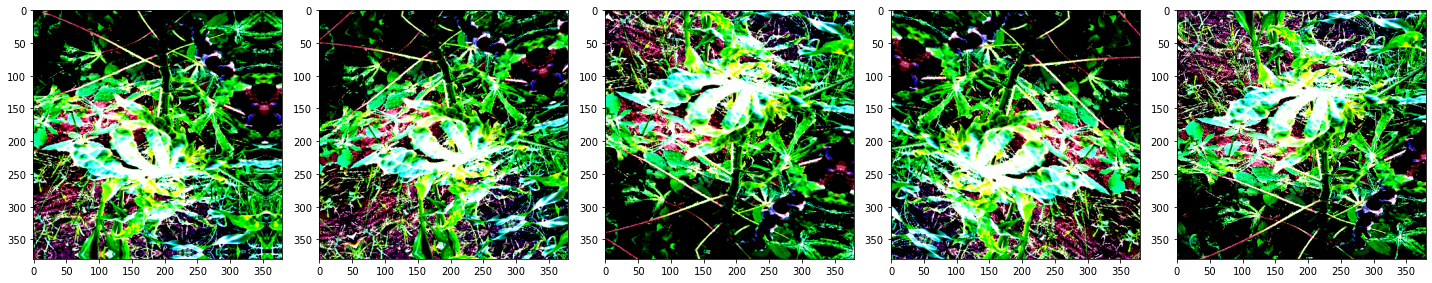

Epoch 1/7
535/535 [==============================] - ETA: 0s - loss: 0.9122 - categorical_accuracy: 0.6680 - AUC: 0.8087
Epoch 00001: val_categorical_accuracy improved from -inf to 0.63870, saving model to ./model_5.h5
535/535 [==============================] - 381s 711ms/step - loss: 0.9122 - categorical_accuracy: 0.6680 - AUC: 0.8087 - val_loss: 1.0147 - val_categorical_accuracy: 0.6387 - val_AUC: 0.7866
Epoch 2/7
535/535 [==============================] - ETA: 0s - loss: 0.5895 - categorical_accuracy: 0.7873 - AUC: 0.9271
Epoch 00002: val_categorical_accuracy improved from 0.63870 to 0.82052, saving model to ./model_5.h5
535/535 [==============================] - 381s 712ms/step - loss: 0.5895 - categorical_accuracy: 0.7873 - AUC: 0.9271 - val_loss: 0.5211 - val_categorical_accuracy: 0.8205 - val_AUC: 0.9422
Epoch 3/7
535/535 [==============================] - ETA: 0s - loss: 0.5002 - categorical_accuracy: 0.8232 - AUC: 0.9461
Epoch 00003: val_categorical_accuracy improved from 0.82

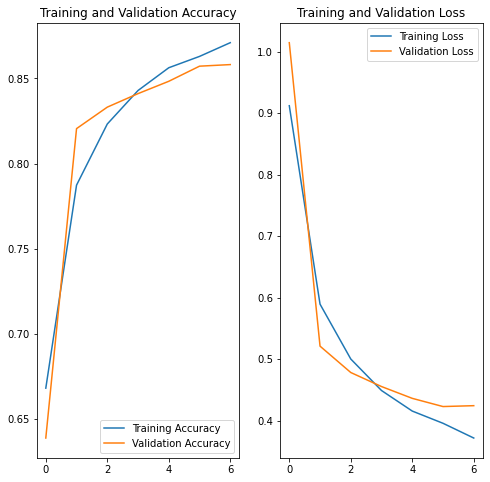

134/134 [==============================] - 62s 465ms/step - loss: 0.4243 - categorical_accuracy: 0.8581 - AUC: 0.9592


In [25]:
ACCURACY = []
LOSS = []
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = './'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(len(X)),Y):
    
    print(f'{fold_var}-fold training')
    training_data = df_train.iloc[train_index]
    validation_data = df_train.iloc[val_index]
    
    # Image Datagenerator
    train_data_gen, valid_data_gen = data_generator(training_data,validation_data)
    
    # plot an augmented sample
    augmented_images = [train_data_gen[0][0][fold_var] for i in range(5)]
    plotImages(augmented_images)

    # CREATE NEW MODEL
    model = create_new_model()
    
    # COMPILE NEW MODEL         
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=10000, decay_rate=0.9)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy',AUC(name="AUC",multi_label=True)])
                                                                                                                                     
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                monitor='val_categorical_accuracy', verbose=1, 
                save_best_only=True, mode='max')
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=2,restore_best_weights=True, verbose=1)
    
    train_step= train_data_gen.n//train_data_gen.batch_size + 1
    valid_step= valid_data_gen.n//valid_data_gen.batch_size + 1
   
   # FIT THE MODEL    
    history = model.fit(train_data_gen,
                        steps_per_epoch= train_step,
                        validation_data = valid_data_gen,
                        validation_steps= valid_step,
                        epochs = 7, 
                        callbacks =  [es,checkpoint])
    
   #PLOT HISTORY
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

   # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("./model_"+str(fold_var)+".h5")

    results = model.evaluate(valid_data_gen)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    ACCURACY.append(acc)
    LOSS.append(loss)

    tf.keras.backend.clear_session()

    fold_var += 1

In [70]:
print('VALIDATION_ACCURACY: {}',np.mean(VALIDATION_ACCURACY))
print('VALIDATION_LOSS: {}',np.mean(VALIDATION_LOSS))

VALIDATION_ACCURACY: {} 0.855633556842804
VALIDATION_LOSS: {} 0.42667242884635925


134/134 [==============================] - 64s 481ms/step


0.8412737601331663

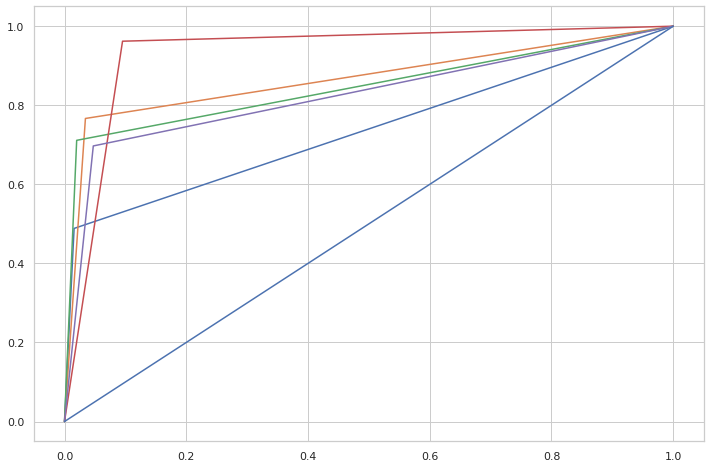

In [77]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(['0','1','2','3','4']): 
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label='ROC curve of class {} (area = {})'.format(c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

valid_data_gen.reset() # resetting generator
y_pred = model.predict_generator(valid_data_gen, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(valid_data_gen.classes, y_pred)

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict_generator(valid_data_gen) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = valid_data_gen.classes

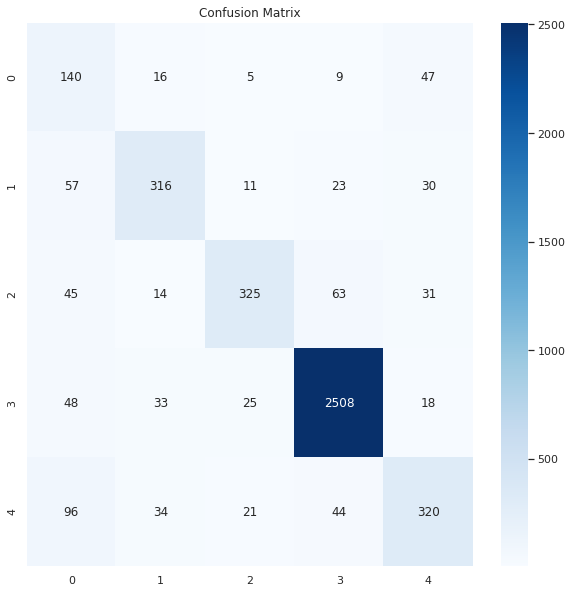

In [33]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style('whitegrid')
cm = confusion_matrix(actual, pred, labels = [0,1,2,3,4])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.title("Confusion Matrix", fontsize=12)
plt.show()

In [34]:
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.36      0.65      0.46       217
           1       0.77      0.72      0.74       437
           2       0.84      0.68      0.75       478
           3       0.95      0.95      0.95      2632
           4       0.72      0.62      0.67       515

    accuracy                           0.84      4279
   macro avg       0.73      0.72      0.72      4279
weighted avg       0.86      0.84      0.85      4279



In [85]:
preds = []
path = '../input/cassava-leaf-disease-classification/test_images'
imgs = os.listdir(path)

for image in imgs:
    img = keras.preprocessing.image.load_img(path + '/' + image)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, 0)
    prediction = model.predict(img)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': imgs, 'label': preds})
my_submiss = pd.DataFrame({'image_id': imgs, 'label': preds})
my_submission.to_csv('./submission.csv', index=False) 
my_submiss.to_csv('./submiss.csv', index=False) 

my_submiss

image_id  label
0  2216849948.jpg      3